<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML2/blob/main/RandomForest/PredictForest_HRHN_NASDAQ_FeatureSelected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K



---


# == Prédiction par RF ==


---



# Chargement et correction des données

Ce dataset est utilisé pour effectuer la prédiction de la température d'une pièce en fonction de plusieurs paramètres mesurés. La fréquence originale des données est d'une minute, puis a été modifiée à 15minutes avec un filtrage. L'ensemble correspond environ à une durée de 40 jours.  
Nous allons utiliser ici la température de la chambre comme cible et sélectionner 18 séries exogènes. 

**1. Chargement des données**

In [2]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/NASDAQ_RFE-CV.csv"
#!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/SMLselected_VSURF_pred.csv"


rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   180  100   180    0     0    125      0  0:00:01  0:00:01 --:--:--   125
100 3965k  100 3965k    0     0  1719k      0  0:00:02  0:00:02 --:--:-- 5351k


**2. Analyse et correction des données**

In [3]:
# Création de la série sous Pandas
df_etude = pd.read_csv("NASDAQ_RFE-CV.csv")
df_etude

Unnamed: 0     AAPL      ADI  ...    PAYX     XLNX       NDX
0               0   96.800  61.1500  ...  60.740  48.6100  4665.054
1               1   96.890  61.6100  ...  60.935  48.7400  4665.054
2               2   96.950  61.9800  ...  61.000  48.9900  4665.826
3               3   96.970  62.0900  ...  61.008  48.9500  4667.081
4               4   96.960  61.8900  ...  61.110  48.8900  4664.491
...           ...      ...      ...  ...     ...      ...       ...
40555       40555  115.880  73.2895  ...  61.035  59.9200  4921.811
40556       40556  115.875  73.2900  ...  61.030  59.9290  4921.580
40557       40557  115.875  73.2850  ...  61.035  59.9345  4921.884
40558       40558  115.920  73.3000  ...  61.050  59.9400  4922.949
40559       40559  115.910  73.2900  ...  61.040  59.9500  4922.942

[40560 rows x 15 columns]

In [4]:
df_etude = df_etude.drop(['Unnamed: 0'],axis=1)
df_etude

AAPL      ADI       ADSK    AVGO  ...     MSFT    PAYX     XLNX       NDX
0       96.800  61.1500  58.180000  161.41  ...  56.5150  60.740  48.6100  4665.054
1       96.890  61.6100  58.190000  161.83  ...  56.7200  60.935  48.7400  4665.054
2       96.950  61.9800  58.203335  162.50  ...  56.7000  61.000  48.9900  4665.826
3       96.970  62.0900  58.216667  162.68  ...  56.6900  61.008  48.9500  4667.081
4       96.960  61.8900  58.230000  162.75  ...  56.6900  61.110  48.8900  4664.491
...        ...      ...        ...     ...  ...      ...     ...      ...       ...
40555  115.880  73.2895  74.690000  179.56  ...  63.5500  61.035  59.9200  4921.811
40556  115.875  73.2900  74.675000  179.62  ...  63.5438  61.030  59.9290  4921.580
40557  115.875  73.2850  74.680000  179.60  ...  63.5410  61.035  59.9345  4921.884
40558  115.920  73.3000  74.750000  179.62  ...  63.5650  61.050  59.9400  4922.949
40559  115.910  73.2900  74.740000  179.56  ...  63.5700  61.040  59.9500  4922.942

[40560 rows x 14 columns]

Affiche les types :

In [5]:
df_etude.dtypes

AAPL     float64
ADI      float64
ADSK     float64
AVGO     float64
BBBY     float64
BIDU     float64
BIIB     float64
EA       float64
GOOGL    float64
LBTYA    float64
MSFT     float64
PAYX     float64
XLNX     float64
NDX      float64
dtype: object

Modifie les type en float32 :

In [6]:
df_etude = df_etude.astype(dtype='float32')
df_etude.dtypes

AAPL     float32
ADI      float32
ADSK     float32
AVGO     float32
BBBY     float32
BIDU     float32
BIIB     float32
EA       float32
GOOGL    float32
LBTYA    float32
MSFT     float32
PAYX     float32
XLNX     float32
NDX      float32
dtype: object

**5. Affiche les données**

In [7]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['NDX'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [8]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 32448
Taille de la validation : 8112


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [9]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [10]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(32448, 14)
(8112, 14)


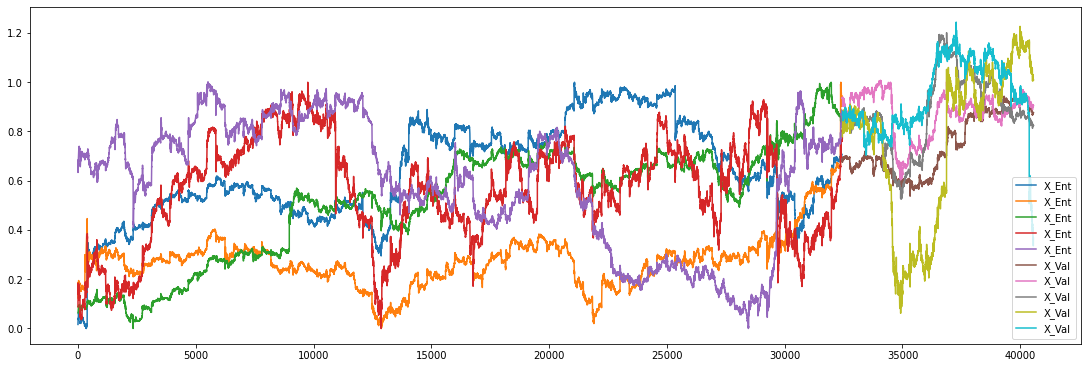

In [11]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création du modèle RF

Recopie des X et des Y et décalage des Y :

In [30]:
X_ent = serie_entrainement_X_norm[:-1,0:-1]
Y_ent = np.roll(serie_entrainement_X_norm[:,-1],shift=-1)
Y_ent = Y_ent[:-1]

In [ ]:
pd.DataFrame(min_max_scaler.transform(df_etude[:temps_separation]))

In [ ]:
X_ent.shape

In [24]:
Y_ent

array([0.06071057, 0.06365313, 0.06843642, ..., 0.85556509, 0.8497935 ,
       0.83489085])

Création du modèle et entrainement :

In [13]:
!pip -q install tensorflow_decision_forests

     |████████████████████████████████| 6.2MB 5.3MB/s 


In [ ]:
import tensorflow_decision_forests as tfdf

model_RF = keras.models.load_model("modelRF")

In [28]:
import tensorflow_decision_forests as tfdf

# Informations sur les données
n = serie_entrainement_X_norm.shape[0]              # Nombre d'observations
p = serie_entrainement_X_norm.shape[1]              # Nombre de variables
mtry = int(p/3)
n_arbres = 10

model_RF = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION,num_trees=n_arbres,verbose=True, min_examples=mtry)
model_RF.fit(x=X_ent,y=Y_ent)

   1/1014 [..............................] - ETA: 1:44

NotFoundError: ignored

In [16]:
model_RF.save("/content/modelRF")

INFO:tensorflow:Assets written to: /content/modelRF/assets


INFO:tensorflow:Assets written to: /content/modelRF/assets


In [16]:
!ls -l

total 3976
drwxr-xr-x 4 root root    4096 Jul 19 13:27 modelRF
-rw-r--r-- 1 root root 4060390 Jul 19 13:27 NASDAQ_RFE-CV.csv
drwxr-xr-x 1 root root    4096 Jul 15 13:38 sample_data


In [15]:
# Informations sur les données
n = serie_entrainement_X_norm.shape[0]              # Nombre d'observations
p = serie_entrainement_X_norm.shape[1]              # Nombre de variables
mtry = np.int32(p/3)
n_arbres = 10

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=mtry, n_jobs=-1)
clf.fit(X_ent,Y_ent)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

# Création des datasets

In [15]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [16]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 1
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [17]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

253
(128, 1, 13)
(128, 1, 1)
(128, 1, 1)


In [18]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

63
(128, 1, 13)
(128, 1, 1)
(128, 1, 1)


**3. Préparation des X/Y**

In [19]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(32384, 1, 13)
(32384, 1, 1)
(32384, 1, 1)


In [20]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(8064, 1, 13)
(8064, 1, 1)
(8064, 1, 1)


# Prédictions par Random Forest

In [23]:
pred_ent_forest = tf.squeeze(model_RF.predict(x_train[0][:,0,:]),-1)
pred_val_forest = tf.squeeze(model_RF.predict(x_val[0][:,0,:]),-1)

InternalError: ignored

In [ ]:
def compute_out():
  model_RF = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION,num_trees=n_arbres,verbose=True, min_examples=mtry)
  model_RF.fit(x=X_ent,y=Y_ent)

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  tf.compat.v1.tpu.outside_compilation(compute_out)

In [23]:
pred_ent_forest = clf.predict(x_train[0][:,0,:])
pred_val_forest = clf.predict(x_val[0][:,0,:])

NameError: ignored

In [48]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index[:temps_separation],y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent_forest)
max = max
for i in range(0,max):
  pred.append(pred_ent_forest[i])
pred = tf.convert_to_tensor(pred).numpy()

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:temps_separation],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val_forest)
max = max
for i in range(0,max):
  pred.append(pred_val_forest[i])

pred = tf.convert_to_tensor(pred).numpy()

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [49]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent_forest)
max = max
for i in range(0,max):
  pred.append(pred_ent_forest[i])
pred = tf.convert_to_tensor(pred).numpy()

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:temps_separation],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:temps_separation],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [50]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val_forest)
max = max
for i in range(0,max):
  pred.append(pred_val_forest[i])
pred = tf.convert_to_tensor(pred).numpy()

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [51]:
print(mse_ent)
print(mse_test)

tf.Tensor(2.6208922e-05, shape=(), dtype=float32)
tf.Tensor(0.0408138, shape=(), dtype=float32)




---


# == Prédiction par RF + HRHN mutualisés ==


---



# Initialisation TPU

In [13]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.108.84.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.108.84.226:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


#Création des datasets

In [14]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [15]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 128
longueur_sequence = 15
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [16]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

253
(128, 15, 13)
(128, 15, 1)
(128, 1, 1)


In [17]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

63
(128, 15, 13)
(128, 15, 1)
(128, 1, 1)


**2. Préparation des X/Y**

In [18]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(32384, 15, 13)
(32384, 15, 1)
(32384, 1, 1)


In [19]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(8064, 15, 13)
(8064, 15, 1)
(8064, 1, 1)


# Création des couches du modèle HRHN

Le modèle HRHN est décrit dans ce document de recherche : [Hierarchical Attention-Based Recurrent Highway Networks for Time Series Prediction](https://arxiv.org/pdf/1806.00685)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Mod%C3%A8leHRHN1.png?raw=true' width=700>

**1. Création de l'encodeur**

L'encodeur a pour but de créer des représentations cachées des séries exogènes qui prennent en compte les relations spatiales entre ces séries ainsi que les relations temporelles.  
Les relations spatiales sont extraitent à l'aide d'un ensemble de réseaux de convolution qui produisent des représentations w1, w2... w(T-1).  
Ces représentations sont ensuites codées par un réseau RHN à 3 couches afin d'en extraire les relations temporelles. En sortie de ce réseau RHN, on extrait 3 tenseurs dont chacun contient les (T-1) états cachés de chaque couche du réseau RHN.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

***a. Création des CNN parallèlisés***

La structure d'un réseau de convolution est composée de trois couches CNN-1D + Max-pooling :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN1.png?raw=true'>

L'intégration de caque réseau dans Keras est parallélisée :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN2.png?raw=true'>

In [20]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]

class Encodeur_CNN(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling,dim_motif):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    super().__init__()                # Appel du __init__() de la classe Layer
  
  # Création de Tin réseaux de convolution + max_pooling en //
  ############################################################
  def build(self,input_shape):
    convs = []
    input_cnns = []

    # Création des Tin entrées des réseaux CNN
    for i in range(input_shape[1]):
        input_cnns.append(tf.keras.Input(shape=(input_shape[2],1)))       # input = Tin*(batch_size,#dim,1)

    # Création des Tin réseaux CNN
    for i in range(input_shape[1]):
      conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[0],      # conv : (batch_size,#dim,16)
                                    kernel_size=self.dim_filtres_cnn[0],
                                    activation='relu',
                                    padding='same',
                                    strides=1)(input_cnns[i])
      conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[0],      # conv : (batch_size,#pooling1,16)
                                       padding='same')(conv)
      for n in range(1,len(self.dim_filtres_cnn)):
        conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                      kernel_size=self.dim_filtres_cnn[n],
                                      activation='relu',
                                      padding='same',
                                      strides=1)(conv)
        conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                         padding='same')(conv)
      convs.append(conv)
    
    # Création de la sortie concaténée des Tin réseaux CNN
    out = tf.convert_to_tensor(convs)                                     # out : (Tin,batch_size,#pooling,64)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,Tin,#pooling,64)
    out = tf.keras.layers.Reshape(                                        # out : (batch_size,Tin,#pooling*64)
        target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)

    out = tf.keras.layers.Dense(units=self.dim_motif)(out)                # out : (batch_size,Tin,dim_motif) 

    # Création du modèle global
    self.conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:  Entrée séries exogènes  : (batch_size,Tin,#dim)
  # Sorties :
  #     w:      Sorties des motifs CNN  : (batch_size,Tin,#pooling,64)
  #                                       (taille dernier filtre=64)
  def call(self, input):
    # Coupes temporelles sur les séries exogènes
    # au format : Tin*(batch_size,#dim,1)
    input_list = []
    for i in range(input.shape[1]):
      input_list.append(tf.transpose(input[:,i:i+1,:],perm=[0,2,1]))      # (batch_size,#dim,1)
    # Convolutions spatiales des séries exogènes
    w = self.conv_model(input_list)                                       # (batch_size,Tin,dim_motif)
    return w

***b. Création des cellules RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_RHN.png?raw=true'>

On crée une cellule RHN en reprenant le code précédent auquel :  
- On ajoute la possibilité de retourner tous les états cachés de chaque couche
- On ajoute la prise en compte de la dimension d'entrée correspondant à la dimension des motifs en sortie des réseaux CNN (dim_motif)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Structure_RHN4.png?raw=true'>

In [21]:
class Cellule_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches, return_all_states = False, dim_input=1):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.dim_input = dim_input
    self.return_all_states = return_all_states
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wh = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wh")       # (#dim, #RHN)
    self.Wt = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wt")       # (#dim, #RHN)
    self.Wc = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wc")       # (#dim, #RHN)

    self.Rh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rh")      # (n_couches,#RHN, #RHN)
    self.Rt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rt")      # (n_couches,#RHN, #RHN)
    self.Rc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rc")      # (n_couches,#RHN, #RHN)

    self.bh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bh")        # (n_couches,#RHN, 1)
    self.bt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bt")        # (n_couches,#RHN, 1)
    self.bc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bc")        # (n_couches,#RHN, 1)

    super().build(input_shape)        # Appel de la méthode build()

    # Initialisation des masques de dropout
  def InitMasquesDropout(self,drop=0.0):
    self.Wh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Rh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)

  # Entrées :
  #     input:          Entrées X[t]        : (batch_size,1,#dim)
  #     init_hidden:    Etat caché Init.    : (batch_size,#RHN)
  # Sorties :
  #     sL:             Etat caché de la dernière couche       : (batch_size,#RHN) 
  #           ou        Etats cachés de chaque couche SL[t]    : (batch_size,nbr_couches,#RHN)
  def call(self, input, init_hidden=None):
    # Construction d'un vecteur d'état nul si besoin
    if init_hidden == None:
      init_hidden = tf.matmul(tf.zeros(shape=(self.dim_RHN,input.shape[2])), # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
                              tf.transpose(input,perm=[0,2,1]))
      init_hidden = tf.squeeze(init_hidden,-1)                               # (batch_size,#RHN,1) => (batch_size,#RHN)
  
    liste_sl = []                                                            # Liste pour  enregistrer les états cachés de chaque couche
    # Calcul de hl, tl et cl
    for i in range(self.nbr_couches):
      if i==0:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[0,:,:],self.Rh[0,:,:])                      # (#RHN,1)_x_(#RHN,#RHN) = (#RHN,#RHN)
        Rt = tf.multiply(self.Rt_[0,:,:],self.Rt[0,:,:])
        Rc = tf.multiply(self.Rc_[0,:,:],self.Rc[0,:,:])

        Wh = tf.multiply(self.Wh_,self.Wh)                                    # (#dim,1)_x_(#dim,#RHN) = (#dim,#RHN)
        Wt = tf.multiply(self.Wt_,self.Wt)
        Wc = tf.multiply(self.Wc_,self.Wc)
   
        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = hl + tf.matmul(tf.transpose(Wh),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tl + tf.matmul(tf.transpose(Wt),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = cl + tf.matmul(tf.transpose(Wc),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)

      else:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[i,:,:],self.Rh[i,:,:])
        Rt = tf.multiply(self.Rt_[i,:,:],self.Rt[i,:,:])
        Rc = tf.multiply(self.Rc_[i,:,:],self.Rc[i,:,:])

        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)
      
      # Calcul de sl
      sl = tf.keras.layers.multiply([hl,tl])                                # (batch_size,#RHN)
      sl = sl + tf.keras.layers.multiply([init_hidden,cl])                  # (batch_size,#RHN)
      liste_sl.append(sl)       # Sauvegarde l'état caché de la couche courante
      init_hidden = sl
    if self.return_all_states == False:
      return sl
    else:
      liste_sl = tf.convert_to_tensor(liste_sl)                             # (nbr_couches,batch_size,#RHN)
      liste_sl = tf.transpose(liste_sl,perm=[1,0,2])                        # (batch_size,nbr_couches,#RHN)
      return liste_sl

***c. Création de l'encodeur : Convolutions + RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

In [22]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]
#   dim_motif         :   dimension du motif en sortie du CNN
#   dim_RHN           :   dimension du vecteur caché RHN
#   nbr_couches_RHN   :   nombre de couches du RHN
#   dropout           :   dropout variationnel pour le RHN ex: [0.1]

class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling, dim_motif,dim_RHN,nbr_couches_RHN, dropout=0.0):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.encodeur_cnn = Encodeur_CNN(dim_filtres_cnn=self.dim_filtres_cnn,nbr_filtres_cnn=self.nbr_filtres_cnn,dim_max_pooling=self.dim_max_pooling,dim_motif=self.dim_motif)
    self.RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=True,dim_input=self.dim_motif)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  # Sorties :
  #     hidden_states   Vecteurs cachés   : (batch_size,nbr_couches,Tin,#RHN)
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.encodeur_cnn(input)      #  (batch_size,Tin,dim_motif)

    # Encodage des motifs CNN avec les cellules RHN
    sequence = []
    hidden = None

    # Initialisation des masques de dropout pour tous les pas de temps
    self.RHN.InitMasquesDropout(self.dropout)

    # Applique la cellule RHN à chaque pas de temps
    for i in range(input.shape[1]):
      hidden = self.RHN(w[:,i:i+1,:],hidden)          # Envoie (batch_size,1,dim_motif)
      sequence.append(hidden)                         # Sauve (batch_size,nbr_couches,#RHN)

      # Le premier état caché du prochain instant
      # est l'état caché de la dernière couche précédente
      hidden = hidden[:,self.nbr_couches_RHN-1,:]       # (batch_size,#RHN)

    # Traite le format des vecteurs cachés de l'encodeur
    sequence = tf.convert_to_tensor(sequence)               # (Tin,batch_size,nbr_couches,#RHN)
    hidden_states = tf.transpose(sequence,perm=[1,2,0,3])   # (batch_size,nbr_couches,Tin,#RHN)  

    return hidden_states

**2. Création du décodeur**

Le décodeur prend en entrée et à chaque pas de temps :  
- Le tenseur en sortie de l'encodeur RHN qui contient l'ensemble des vecteurs cachés des différentes couches : (batch_size,Nbr_couches,Tin,#RHN)
- L'état caché de la dernière couche du décodeur RHN précédent : (batch_size,#RHN)
- La valeur de la série cible à l'instant courant : (batch_size,1,1)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_VueEnsembleDecodeur2.png?raw=true'>

**a. Création de la couche d'attention hiérarchique**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_AttentionHierarchique.png?raw=true'>

On commence par créer la fonction permettant de calculer les scores. Cette fonction sera appelée avec la méthode TimeDistributed de Keras.

In [23]:
class CalculScore(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.T = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="T")            # (#RHN, #RHN)
    self.U = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="U")            # (#RHN, #RHN)
    self.b = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="b")                         # (#RHN, 1)
    self.v = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="v")                         # (#RHN, 1)
    super().build(input_shape)        # Appel de la méthode build()

  #     hid_state:  Etat initial RHN          : (batch_size,#RHN)
  def SetInitState(self,hid_state):
    self.hid_state = hid_state

  def compute_output_shape(self,input_shape):
    return(input_shape[0],1)

  # Entrées :
  #     input:      1 sortie encodeur RHN     : (batch_size,#RHN)
  # Sorties :
  #     score:      score                     : (batch_size,1,1)
  def call(self, input):
    score = tf.matmul(self.U,tf.expand_dims(input,-1))                      # (#RHN,#RHN)x(batch_size,#RHN,1) = (batch_size,#RHN,1)
    score = score + tf.matmul(self.T,tf.expand_dims(self.hid_state,-1))     # (batch_size,#RHN,1)
    score = score + self.b                                                  # (batch_size,#RHN,1)
    score = K.tanh(score)
    score = tf.matmul(tf.transpose(self.v),score)                           # (1,#RHN)x(batch_size,#RHN,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                             # (batch_size,1)

On crée maintenant la couche d'attention hiérarchique :

In [24]:
class AttentionHierarchique(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_score = CalculScore()
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties d'une couche encodeur RHN       : (batch_size,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  # Sorties :
  #     vc:         SousVecteur contexte                    : (batch_size,1,RHN)
  def call(self, input, hid_state):
    # Calcul des scores
    self.couche_score.SetInitState(hid_state)
    scores = tf.keras.layers.TimeDistributed(self.couche_score)(input)        # (batch_size,Tin,#RHN) : Timestep = Tin
                                                                              # (batch_size,#RHN) envoyé Tin fois
                                                                              # (batch_size,Tin,1) retourné
    scores = tf.keras.activations.softmax(scores,axis=1)                      # (batch_size,Tin,1)

    # Applique les scores aux sorties de la couche RHN
    poids = tf.multiply(input,scores)             # (batch_size,Tin,#RHN)_x_(batch_size,Tin,1) = (batch_size,Tin,#RHN)

    # Calcul le sous-vecteur contexte
    vc = K.sum(poids,axis=1)                      # (batch_size,#RHN)
    return tf.expand_dims(vc,1)                   # (batch_size,1,#RHN)

**b. Création du décodeur**

Dans le décodeur, on parallélise autant de couches d'attention que nécessaire afin de créer un modèle d'attention multi-entrées.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ParaDecodeur.png?raw=true'>

In [25]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_RHN,nbr_couches_RHN,dropout=0.0):
    self.dim_RHN = dim_RHN
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    attentions = []
    inputs_attention = []

    # Création des "nbr_couches" entrées des attentions
    # Chaque entrée est une liste : [input,init_state] = [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    for i in range(input_shape[1]):
      inputs_attention.append([tf.keras.Input(shape=(input_shape[2],input_shape[3])),          # input = "nbr_couches"*(batch_size,Tin,#RHN)
                                 tf.keras.Input(shape=(input_shape[3]))])                      # init_state = "nbr_couches"*(batch_size,#RHN)

    # Création des "nbr_couches" couches d'attentions hierarchiques
    for i in range(input_shape[1]):
      att = AttentionHierarchique()(inputs_attention[i][0],                 # inputs_attention[i][0] : (batch_size,Tin,#RHN)
                                    inputs_attention[i][1])                 # inputs_attention[i][1] : (batch_size,#RHN)
      attentions.append(att)

    # Création de la sortie concaténée des "nbr_couches" couches d'attentions
    out = tf.convert_to_tensor(attentions)                                # out : (nbr_couches,batch_size,1,#RHN)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,nbr_couches,1,#RHN)

    # Création du modèle global
    self.att_model = tf.keras.Model(inputs=inputs_attention,outputs=out)

    # Création des poids
    self.Wtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.Vtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)

    # Création du décodeur RHN
    self.dec_RHN = Cellule_RHN(dim_RHN=self.dim_RHN,nbr_couches=self.nbr_couches_RHN,return_all_states=False,dim_input=1)
   
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties des couches de l'encodeur RHN   : (batch_size,nbr_couches,Tin,#RHN)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN)
  #     Y:          Valeur de la série cible                : (batch_size,1)
  #     only_att    Si =True ne calcul que le vecteur ctx   : True/False
  # Sorties :
  #     d:          Vecteur contexte                        : (batch_size,nbr_couches*RHN)
  #     s:          Vecteur caché décodeur RHN              : (batch_size,#RHN)
  def call(self, input, hid_state, Y,only_att):
    # Initialisation de l'état caché à 0 si besoin
    # Construit le tenseur nul au format (batch_size,#RHN)
    if hid_state == None:
      coef = tf.expand_dims(input[:,0,0,0],-1)                        # (batch_size,1)
      coef = tf.expand_dims(coef,-1)                                  # (batch_size,1,1)
      hid_state = tf.matmul(coef,tf.zeros(shape=(1,input.shape[3])))  # (batch_size,1,1)X(1,#RHN) = (batch_size,1,#RHN)
      hid_state = tf.squeeze(hid_state,axis=1)                        # (batch_size,#RHN)

    # Construction de l'entrée du modèle
    # nbr_couches*[((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    input_model = []
    for i in range(input.shape[1]):
      input_model.append([input[:,i,:,:],hid_state])    # [((batch_size,Tin,#RHN)),((batch_size,#RHN))]
    
    # Calcul des sous-vecteurs contextes
    # avec le modèle d'attention hiérarchique parallélisé
    d = self.att_model(input_model)                     # d : (batch_size,nbr_couches,1,#RHN)

    # Concaténation des sous-vecteurs contextes
    d = tf.squeeze(d,axis=2)                            # (batch_size,nbr_couches,#RHN)
    d = tf.keras.layers.Flatten()(d)                    # (batch_size,nbr_couches*RHN)

    if only_att == False :
      # Calcul de y_tilda
      ytilda = self.Wtilda(Y)                             # (batch_size,1)
      ytilda = ytilda + self.Vtilda(d)                    # (batch_size,1)

      # Initialisation des masques de dropout pour tous les pas de temps
      self.dec_RHN.InitMasquesDropout(self.dropout)

      # Décodage avec le réseau RHN
      s = self.dec_RHN(tf.expand_dims(ytilda,-1),hid_state)                  # (batch_size,#RHN)
      return d,s
    else:
      return d

**3. Création de la couche HRHN**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Gene_HRHN.png?raw=true'>

In [26]:
class Net_HRHN(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, dim_RHN, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.regul = regul
    self.drop = drop
    self.dim_RHN = dim_RHN
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.V = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Appel de l'encodeur
    # Récupère l'ensemble des états cachés de l'encodeur RHN
    H = self.encodeur(input)                # (batch_size,nbr_couches,Tin,#RHN)

    # Décodage
    hidden_state = None
    for t in range(input.shape[1]):
      vc, hidden_state = self.decodeur(H,hidden_state,output_seq[:,t:t+1,0],only_att = False)
    
    # Couche d'attention finale
    vc = self.decodeur(H,hidden_state,output_seq[:,0,0],only_att=True)

    # Génération de la prédiction par HRHN
    sortie = self.W(hidden_state) + self.V(vc)        # (batch_size,1)

    return tf.expand_dims(sortie,-1)                  # (batch_size,1,1)

# Création du modèle HRHN + RF - KERAS

In [40]:
entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]),batch_size=batch_size)
sortie_RF = clf.predict(entrees_sequences[:,longueur_sequence-1,:])          # => (bs,1,1)

model = tf.keras.Model(entrees_sequences,sortie_RF)

TypeError: ignored

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 15, 13)]           0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (128, 13)                 0         
_________________________________________________________________
random_forest_model (RandomF (128, 1)                  1         
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


In [27]:
dim_RHN = 128
dim_filtres_cnn = [16,32,64]
nbr_filtres_cnn = [3,3,3]
dim_max_pooling = [3,3,3]
nbr_couches_RHN = 3
dim_motif = 3
drop=0.00

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]),batch_size=batch_size)
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1),batch_size=batch_size)

  encodeur = Encodeur(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=dim_motif,dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)
  decodeur = Decodeur(dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)

  # Prédiction avec le modèle HRHN
  sortie_HRHN = Net_HRHN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_RHN=dim_RHN,drop=drop)(entrees_sequences,sorties_sequence)     # => (bs,1,1)
  
  # Prédiction avec le modèle RF
  sortie_RF = model_RF(entrees_sequences[:,longueur_sequence-1,:],training=False)          # => (bs,1,1)

  # Combinaison des deux prédictions
  sortie = tf.keras.layers.Add()([sortie_HRHN,sortie_RF])
  sortie = tf.keras.layers.Dense(units=1)(sortie)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Entrainement avec GPU

In [64]:
  from google.colab import files

  max_periodes = 1000


  # Création du modèle
  model = get_model()
  
  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.003,
      decay_steps=20,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)],batch_size=batch_size)

  files.download('poids_train.hdf5')

Epoch 1/1000
 11/253 [>.............................] - ETA: 4:22 - loss: 0.0189 - mse: 0.0189

KeyboardInterrupt: ignored

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Création du modèle HRHN + RF

In [33]:
class CustomModel(keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
    
    def call(self, inputs, training=False):
        # inputs : (X1,X2)

        X1 = inputs[0]                                # Séries exogènes : (batch_size,longueur_sequence,n)
        X2 = inputs[1]                                # Cibles : (batch_size,longueur_sequence,1)

        sortie = clf.predict(tf.convert_to_tensor(X1[:,13,:]))
        return sortie

In [27]:
class CustomModel(keras.Model):
    def __init__(self,clf):
        super(CustomModel, self).__init__()
        self.clf = clf

    def call(self, inputs, training=False):
        out = self.clf.predict(np.asarray(inputs))
        return out

In [ ]:
clf.p

In [34]:
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  clf = RandomForestRegressor(n_estimators=20, bootstrap=True, oob_score=True, max_features=2)
  clf.fit(X_ent,Y_ent)

  model = CustomModel(clf)
  model.compile(loss="mse")
  model.fit(X_ent)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:815: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.



TypeError: ignored

In [108]:
!pip install -U numpy==1.18.5

     |████████████████████████████████| 20.1MB 154kB/s 
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [64]:
clf.predict(X_ent)

array([0.05620795, 0.05802281, 0.06297463, ..., 0.85260336, 0.85089521,
       0.83865885])

In [48]:
with tf.device(None):
  clf.predict(X_ent)

In [ ]:
# Informations sur les données
n = serie_entrainement_X_norm.shape[0]              # Nombre d'observations
p = serie_entrainement_X_norm.shape[1]              # Nombre de variables
mtry = np.int32(p/3)
n_arbres = 2000

clf = RandomForestRegressor(n_estimators=n_arbres, bootstrap=True, oob_score=True, max_features=mtry, n_jobs=-1)
clf.fit(X_ent,Y_ent)

In [ ]:
def RandomForest(x):
  return clf.predict(x)

def get_model_RF():
  entrees_series = tf.keras.layers.Input(shape=(x_train[0].shape[2]))

  sortie_RF = tf.keras.layers.Lambda(RandomForest)(entrees_series)

  model = tf.keras.Model(entrees_series,sortie_RF)
  return model

In [ ]:
get_model_RF()

In [ ]:
dim_RHN = 128
dim_filtres_cnn = [16,32,64]
nbr_filtres_cnn = [3,3,3]
dim_max_pooling = [3,3,3]
nbr_couches_RHN = 3
dim_motif = 3
drop=0.00

def get_model():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1))

  encodeur = Encodeur(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=dim_motif,dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)
  decodeur = Decodeur(dim_RHN=dim_RHN,nbr_couches_RHN=nbr_couches_RHN,dropout=drop)

  # Prédiction avec le modèle HRHN
  sortie_HRHN = Net_HRHN(encodeur,decodeur,longueur_sequence=longueur_sequence,dim_RHN=dim_RHN,drop=drop)(entrees_sequences,sorties_sequence)
  
  # Prédiction avec le modèle RF
  print(entrees_sequences[:,0,:].shape)
  sortie_RF = clf.predict(entrees_sequences[:,longueur_sequence-1,:])
  sortie_RF = tf.expand_dims(sortie_RF,-1)

  # Combinaison des deux prédictions
  sortie = tf.keras.layers.Add()[sortie_HRHN,sortie_RF]
  sortie = tf.keras.layers.Dense(units=1)(sortie)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

In [ ]:
get_model()

(None, 13)


TypeError: ignored

# Entrainement avec TPU

In [ ]:
import tensorflow_decision_forests as tfdf

# Informations sur les données
n = serie_entrainement_X_norm.shape[0]              # Nombre d'observations
p = serie_entrainement_X_norm.shape[1]              # Nombre de variables
mtry = int(p/3)
n_arbres = 10

model_RF = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION,num_trees=n_arbres,verbose=True, min_examples=mtry)
model_RF.fit(x=X_ent,y=Y_ent)

In [29]:
!pip install -q tensorflow_decision_forests

     |████████████████████████████████| 6.2MB 5.4MB/s 


In [31]:
from google.colab import files
import tensorflow_decision_forests as tfdf

# Informations sur les données
n = serie_entrainement_X_norm.shape[0]              # Nombre d'observations
p = serie_entrainement_X_norm.shape[1]              # Nombre de variables
mtry = int(p/3)
n_arbres = 10
max_periodes = 1000

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle global
  model = get_model()

  
  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.003,
      decay_steps=20,
      decay_rate=0.01)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)],batch_size=batch_size)

files.download('poids_train.hdf5')

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


1005/1014 [============================>.] - ETA: 0s

NotFoundError: ignored

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Chargement du modèle pré-entrainé

**DSTP-RF_NASDAQ_RFE-CV_15**

  - Vecteur LSTM : 128
  - Longueur entrée : 15  
  - Longueur sortie : 1
  - Drop : 0.0
  - L2 : 0.00  
  - Batch Size : 128  
  - Périodes : 1000   
	=> mse :   4.2280e-05 / 3.1884e-05  
  (Naïve : 4.2276e-05 ; 3.1951e-05)


In [ ]:
model = get_model()

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

In [ ]:
!rm *.hdf5
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Models/DSTP_RF_15.hdf5"

In [ ]:
model.load_weights("DSTP_RF_15.hdf5")

# Prédictions single-step

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)